In [1]:
import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
from time import time

is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
    
torch.set_printoptions(precision=3, sci_mode=False)
np.set_printoptions(suppress=True)

In [2]:
data = torch.load('../data.pt')

for dataset in data:
    data[dataset] = data[dataset].float()

In [7]:
from lib.Baseline import ConditionalGenerator, Critic
from lib.Utilities import get_n_params
from lib.Training_wgan import gradient_penalty

In [4]:
hp = {'gp_lambda': 10, 'nsteps_disc': 10, 'batch_size': 64}

In [5]:
x_length = np.arange(2, 400, 20).tolist()
x_length_time = torch.zeros([len(x_length), 25])
x_length_memory = torch.zeros([len(x_length), 25])

In [8]:
for i in range(len(x_length)):
    
    x_length_ = x_length[i]
    X_train = data['X_train'][:, -x_length_:]
    
    
    C = Critic(input_size = [1,1], hidden_size = [32,32], num_layers = [5,5], sep=X_train.shape[1]).float().to(device)
    G = ConditionalGenerator(1, 1, 32, 5, 5).float().to('cuda')
    
    G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3)
    C_optimizer = torch.optim.Adam(C.parameters(), lr=1e-3)

    q = data['Y_train'].shape[1]-1

    train_dataset = TensorDataset(X_train[:, :, 1:], data['Y_train'][:, :, 1:])
    train_dataloader = DataLoader(train_dataset, batch_size = hp['batch_size'], shuffle=True)
    infinite_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    G, C = G.to(device), C.to(device)

    trange = tqdm(range(25))
    for step in trange:
        start_time = time()
        for param in G.parameters():
            param.requires_grad = False
        for param in C.parameters():
            param.requires_grad = True

        for _ in range(hp['nsteps_disc']):
            C_optimizer.zero_grad()
            batch_x, batch_y_real = next(infinite_dataloader)
            batch_x, batch_y_real = batch_x.to(device), batch_y_real.to(device)
            batch_y_fake = G(batch_x, batch_y_real.shape[1]-1)
            batch_real = torch.cat([batch_x, batch_y_real], dim=1)
            batch_fake = torch.cat([batch_x, batch_y_fake], dim=1)
            fake_score, real_score = torch.mean(C(batch_fake)), torch.mean(C(batch_real))
            gp = gradient_penalty(C, batch_real.detach(), batch_fake.detach())
            loss = fake_score - real_score + hp['gp_lambda']*gp
            loss.backward()
            C_optimizer.step()

            del batch_x, batch_y_real, batch_y_fake, batch_real, batch_fake

        for param in G.parameters():
            param.requires_grad = True
        for param in C.parameters():
            param.requires_grad = False

        G_optimizer.zero_grad()
        batch_x, batch_y_real = next(infinite_dataloader)
        batch_x, batch_y_real = batch_x.to(device), batch_y_real.to(device)
        batch_y_fake = G(batch_x, batch_y_real.shape[1]-1)
        batch_fake = torch.cat([batch_x, batch_y_fake], dim=1)
        fake_score = torch.mean(C(batch_fake))
        loss = -fake_score 
        loss.backward()
        G_optimizer.step()

        del batch_x, batch_y_real, batch_y_fake, batch_fake
        end_time = time()
        x_length_time[i, step] = end_time-start_time
        x_length_memory[i, step] = torch.cuda.max_memory_allocated(device='cuda')*1e-6
        torch.cuda.reset_max_memory_allocated(device='cuda')
    

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\pere9\anaconda3\envs\tfm\lib\site-packages\torch\cuda\memory.py:260: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
100%|██████████| 25/25 [24:33<00:00, 58.93s/it]


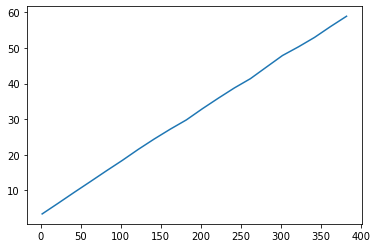

In [9]:
plt.plot(x_length, torch.mean(x_length_time, dim=1))

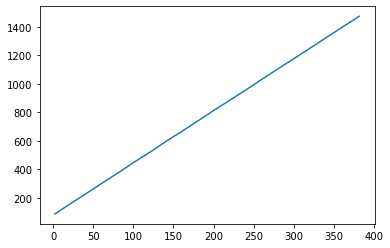

In [10]:
plt.plot(x_length, torch.mean(x_length_memory, dim=1))

In [12]:
torch.save(torch.mean(x_length_time, dim=1), 'x_length_time.pt')

In [11]:
torch.save(torch.mean(x_length_memory, dim=1), 'x_length_memory.pt')